# 1. Importing required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# 2. Loading the dataset

Splitting the dataset into **Training Set**, **Cross Validation Set** and **Test Set** as:

- $\text{Training Set} = \text{80%}$,<br>
- $\text{Validation Set} = \text{10%}$, <br>
- $\text{Test Set} = \text{10%}$

Image dimnesions used are `224 x 224` and batch size of `16`

In [2]:
image_size = 224
batch_size = 8

train_ds = tf.keras.utils.image_dataset_from_directory(
  'training_set/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  'training_set/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

Found 6730 files belonging to 4 classes.
Using 5384 files for training.
Found 6730 files belonging to 4 classes.
Using 1346 files for validation.


In [3]:
class_names = train_ds.class_names

In [4]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

### Visualizing the dataset

In [5]:
cv = len(os.listdir(os.path.join("training_set",class_names[0])))
nm = len(os.listdir(os.path.join("training_set",class_names[1])))
pn = len(os.listdir(os.path.join("training_set",class_names[2])))
tb = len(os.listdir(os.path.join("training_set",class_names[3])))

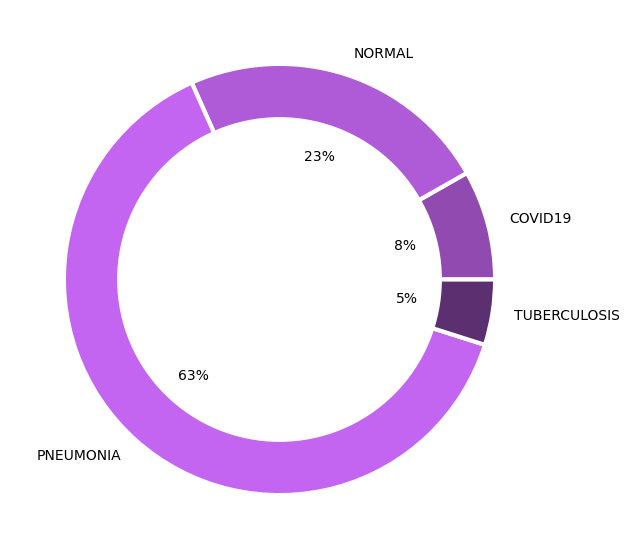

In [6]:
plt.figure(figsize=(7,7))

y = np.array([cv,nm,pn,tb])
max_val = np.max(y)
plt.pie(y, labels=class_names, autopct="%.0f%%",
        colors=["#904AB0","#AF5AD6","#C365F0","#5C2F70"],wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
my_circle=plt.Circle((0,0), 0.75, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Finding class weights to reduce the imbalance

In [7]:
class_weights = {0:max_val/(4*cv),1:max_val/(4*nm),2:max_val/(4*pn),3:max_val/(4*tb)}
class_weights

# 3. Configuring dataset for better performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# 4. Creating the model architecture

In [11]:
model = tf.keras.models.Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Conv2D(32,(3,3),padding='same',activation='relu'),
    layers.Conv2D(32,(3,3),padding='same',activation='relu'),
    layers.MaxPool2D((2,2),padding='same'),
    layers.Conv2D(64,(3,3),padding='same',activation='relu'),
    layers.Conv2D(64,(3,3),padding='same',activation='relu'),
    layers.MaxPool2D((2,2),padding="same"),
    layers.Conv2D(128,(3,3),padding='same',activation='relu'),
    layers.Conv2D(128,(3,3),padding='same',activation='relu'),
    layers.MaxPool2D((2,2),padding='same'),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(class_names))
])

# 5. Compiling the model

Using `SparseCategoricalCrossentropy` loss and `learning rate = 0.00008`

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.00008),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 6. Training the model

Using: 
- Early Stopping to stop training when validation loss has stopped improving
- Saving weights on all iterations
- Saving weights if they produce the best validaton accuracy
- Saving the trained model

Initial number of `epochs = 60`

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.001, restore_best_weights=True)

cp = tf.keras.callbacks.ModelCheckpoint(filepath="training_weights/checkpoints/cp-{epoch}.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

best = tf.keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model_best_val_accuracy.ckpt",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)
history = model.fit(train_ds,
                    epochs=60,
                    validation_data=val_ds,
                   callbacks=[es,cp,best],
                    class_weight=class_weights
                   )
model.save('training_weights/models/model.h5')

Epoch 1/60
673/673 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.7585
Epoch 1: saving model to training_weights/checkpoints\cp-1.ckpt
673/673 [==============================] - 53s 71ms/step - loss: 0.5156 - accuracy: 0.7585 - val_loss: 0.2499 - val_accuracy: 0.9228
Epoch 2/60
673/673 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.8718
Epoch 2: saving model to training_weights/checkpoints\cp-2.ckpt
673/673 [==============================] - 48s 70ms/step - loss: 0.2288 - accuracy: 0.8718 - val_loss: 0.2056 - val_accuracy: 0.9288
Epoch 3/60
673/673 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.8930
Epoch 3: saving model to training_weights/checkpoints\cp-3.ckpt
673/673 [==============================] - 48s 71ms/step - loss: 0.1844 - accuracy: 0.8930 - val_loss: 0.2243 - val_accuracy: 0.9169
Epoch 4/60
673/673 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9160
Epoch 4: saving model to 

# 8. Plotting the learning curves

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

### Loss Graph

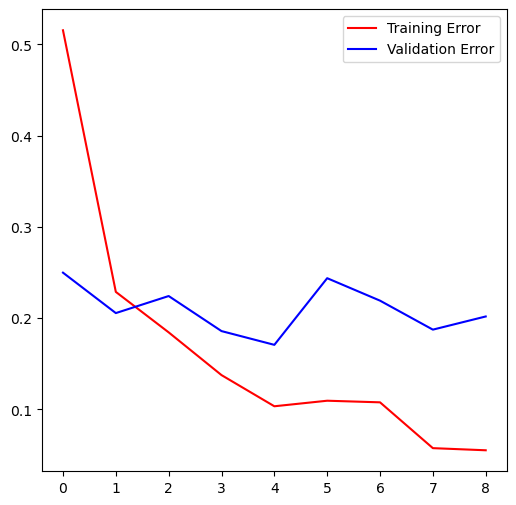

In [15]:
plt.figure(figsize=(6,6))
plt.plot(loss,color='r',label='Training Error')
plt.plot(val_loss, color='b',label='Validation Error')
plt.legend()
plt.show()

### Accuracy Graph

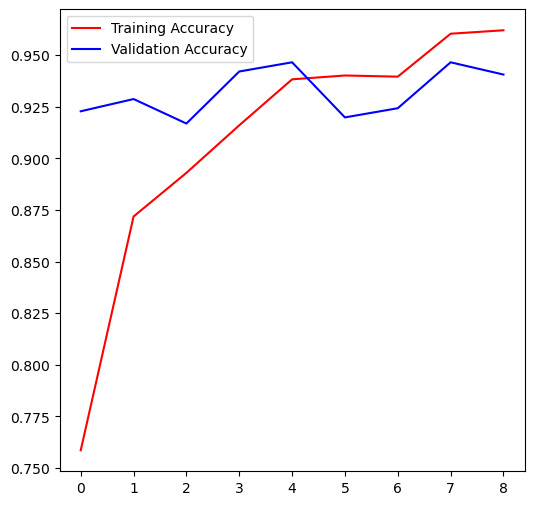

In [16]:
plt.figure(figsize=(6,6))
plt.plot(accuracy,color='r',label='Training Accuracy')
plt.plot(val_accuracy, color='b',label='Validation Accuracy')
plt.legend()
plt.show()

# 9. Evaluating the model on the test set

In [17]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print("Loss on test set: {}".format(test_loss))
print("Accuracy on test set: {:.4f}%".format(test_accuracy*100))

Loss on test set: 0.19293446838855743
Accuracy on test set: 93.3036%


# 10. Plotting the Confusion Matrix

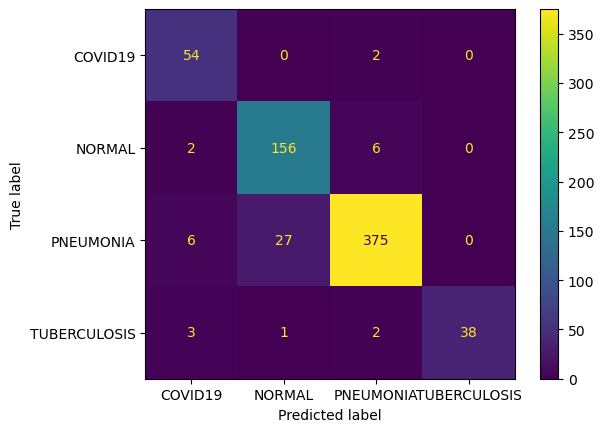

49


In [19]:
y_true = []
y_predicted = []
bads =[]
images = []
for image,label in test_ds:
    for i in label:
        y_true.append(i.numpy())
    for i in model.predict(image,verbose=0):
       y_predicted.append(np.argmax(i)) 
    for i in image:
        images.append(image)
for i in range(len(images)):
    if y_true[i] != y_predicted[i]:
        bads.append(images[i])
y_true = np.array(y_true)
y_predicted = np.array(y_predicted)
cm = confusion_matrix(y_true, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show()
print(len(bads))

# 11. Saving the final model

In [45]:
model.save('model/model.h5')

# 12. Making test predictions

In [65]:
image = tf.keras.utils.load_img("test_image/Normal/5.jpeg")
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])
input_arr = tf.image.resize(input_arr,(224,224))
predictions = model.predict(input_arr,verbose=0)
score = tf.nn.softmax(predictions[0])
predicted_class = class_names[np.argmax(predictions)]
print('The person most likely has {} \nProbability = {:.2f}%'.format(predicted_class,100*np.max(score)))

The person most likely has NORMAL 
Probability = 46.72%
